# Korišćenje neuronskih mreža u regresionim zadacima

Ovaj primer će demonstrirati korišćenje Keras biblioteke u zadacima regresije. Na osnovu već poznatog skupa podataka Boston Housing koji sadrži informacije o nekretninama, potrebno je napraviti neuronski model koji će predvideti cenu nekretnine. Uz ovo, naučićemo i kako možemo sačuvati naučene modele i kasnije ih upotrebiti. 

Pre nego li počnemo sa radom, uključićemo sve potrebne biblioteke.

In [1]:
import torch
import torch.nn as nn

In [2]:
import numpy as np
np.random.seed(7)

In [3]:
from matplotlib import pyplot as plt

In [4]:
from sklearn import preprocessing
from sklearn import model_selection

In [5]:
import pandas as pd

### Korak 1: Priprema skupa podataka

Prvo ćemo učitati skup podataka. Iskoristićemo *Boston housing* skup podataka.

In [6]:
data = pd.read_csv('data/boston.csv')

In [7]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [8]:
X = data.drop(columns=['MEDV'])
y = data['MEDV']
X_train_valid, X_test, y_train_valid, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=7)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=7)

In [9]:
print("X_train", X_train.shape, type(X_train))
print("y_train", y_train.shape, type(y_train))
print("X_valid", X_valid.shape, type(X_valid))
print("y_valid", y_valid.shape, type(y_valid))
print("X_test", X_test.shape, type(X_test))
print("y_test", y_test.shape, type(y_test))

X_train (271, 13) <class 'pandas.core.frame.DataFrame'>
y_train (271,) <class 'pandas.core.series.Series'>
X_valid (68, 13) <class 'pandas.core.frame.DataFrame'>
y_valid (68,) <class 'pandas.core.series.Series'>
X_test (167, 13) <class 'pandas.core.frame.DataFrame'>
y_test (167,) <class 'pandas.core.series.Series'>


Nakon učitavanja, podatke ćemo i standardizovati.

In [10]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [11]:
print("X_train", X_train.shape, type(X_train))
print("y_train", y_train.shape, type(y_train))
print("X_valid", X_valid.shape, type(X_valid))
print("y_valid", y_valid.shape, type(y_valid))
print("X_test", X_test.shape, type(X_test))
print("y_test", y_test.shape, type(y_test))

X_train (271, 13) <class 'numpy.ndarray'>
y_train (271,) <class 'pandas.core.series.Series'>
X_valid (68, 13) <class 'numpy.ndarray'>
y_valid (68,) <class 'pandas.core.series.Series'>
X_test (167, 13) <class 'numpy.ndarray'>
y_test (167,) <class 'pandas.core.series.Series'>


### Korak 2: Kreiranje mreže

Mreža koju ćemo napraviti će biti mreža sa propagacijom unapred. Imaće ulazni sloj, jedan skriveni sloj sa 100 neurona i izlazni sloj. Broj neurona ulaznog sloja odgovara broju atributa skupa podataka (13). Broj neurona izlaznog sloja je 1 jer mreža treba da predvidi cenu nekretnine. Za aktivacionu funkciju prvog sloja odabraćemo `ReLu`, dok ćemo za drugi, izlazni sloj, ostaviti podrazumevanu linearnu aktivaciju `a(x)=x` koja je standardni izbor u slučajevima regresionih zadataka. Druge aktivacione funkcije bi ograničavale opsege koje mreža može da nauči što je u suprotnosti sa očekivanjima regresionih zadataka. 

In [12]:
number_of_features = X_train.shape[1]
output_size = 1

In [13]:
class RegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(RegressionModel, self).__init__()
        layers = [
            nn.Linear(input_size, 100),
            nn.ReLU(),
            nn.Linear(100, output_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):     
        return self.model(x)

In [14]:
model = RegressionModel(number_of_features, output_size)
print(model)

RegressionModel(
  (model): Sequential(
    (0): Linear(in_features=13, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)


### Korak 3: Treniranje mreže

Alternativni način zadavanja optimizatora uz finija podešavanja parametara se može postići uključivanjem `optimizer` paketa, a funkcija gubitka uključivanjem `losses` paketa. Zahvaljujući ovim paketima umesto inicijalizacije niskama, potrebne parametre možemo inicijalizovati instancama odgovarajućih klasa. Tako ćemo prilikom treniranja mreže odabrati srednjekvadratnu grešku (engl. mean squared error) predstavljenu klasom `MeanSquaredError` kao funkciju greške, a srednju apsolutnu grešku predstavljenu klasom `MeanAbsoluteError` kao funkciju čiju ćemo vrednost pratiti u toku obučavanja. Kao optimizator ćemo odabrati Adam. On je predstavljen klasom `Adam`. 

Sada ćemo prilikom treniranja mreže, jedan deo podataka iskoristiti za validaciju. Parametar `validation_split` omogućava da se u zadatoj srazmeri izdvoji deo skupa za treniranje koji će biti korišćen isključivo za validaciju, tj. za monitoring rada mreže. Na kraju svake epohe nad ovim skupom će biti izračunate i sačuvane metrike zadate na nivou modela. Alternativa ovom pristupu bi bilo zadavanje eksplicitno pripremljenog validacionog skupa u formi `(X_validation, y_validation)` preko parametra `validation_data`.

Mrežu ćemo trenirati u 100 epoha sa paketićima veličine 32 instance. Ovoga puta ćemo postaviti i `verbose` parametar funkcije na vrednost 1 kako bismo mogli da pratimo ispise u toku izvršavanja funkcije.

In [15]:
N_EPOCHS = 100
BATCH_SIZE = 32

In [21]:
from torch.utils.data import TensorDataset, DataLoader

X_train, y_train = torch.FloatTensor(X_train), torch.FloatTensor(y_train.to_numpy())
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

X_valid, y_valid = torch.FloatTensor(X_valid), torch.FloatTensor(y_valid.to_numpy())
valid_dataset = TensorDataset(X_valid, y_valid)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=len(valid_dataset), shuffle=False)

AttributeError: 'Tensor' object has no attribute 'to_numpy'

In [17]:
from torch.optim import Adam
from tqdm import trange
from collections import defaultdict
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

optimizer = Adam(params=model.parameters())
metrics = defaultdict(lambda: {'train': [], 'valid': []})

best_valid_loss = float('inf')
for epoch in trange(N_EPOCHS):
    epoch_train_loss, epoch_train_mae = 0, 0
    epoch_valid_loss, epoch_valid_mae = 0, 0
    train_steps, valid_steps = 0, 0
    
    # Training phase
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = (predictions - labels).pow(2).mean()
        mae = (predictions - labels).abs().mean()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        epoch_train_mae += mae.item()
        train_steps += 1

    # Validation phase
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            predictions = model(inputs)
            loss = (predictions - labels).pow(2).mean()
            mae = (predictions - labels).abs().mean()
            
            epoch_valid_loss += loss.item()
            epoch_valid_mae += mae.item()
            valid_steps += 1

    # Average metrics for the epoch
    avg_train_loss = epoch_train_loss / train_steps
    avg_train_mae = epoch_train_mae / train_steps
    avg_valid_loss = epoch_valid_loss / valid_steps
    avg_valid_mae = epoch_valid_mae / valid_steps
    
    metrics['loss']['train'].append(avg_train_loss)
    metrics['mae']['train'].append(avg_train_mae)
    metrics['loss']['valid'].append(avg_valid_loss)
    metrics['mae']['valid'].append(avg_valid_mae)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.47it/s]


Iz ispisa možemo primetiti da se nakon svake epohe računaju vrednosti funkcije gubitka (loss) i srednje apsolutne greške (mean_absolute_error) na skupu za treniranja, kao i njihove vrednosti na skupu za validaciju (val_loss i val_mean_absolute_error).

Prvo ćemo prikazati na zajedničkom grafiku funkcije gubitka na skupu za treniranje i validaciju, a potom i srednju apsolutnu grešku.

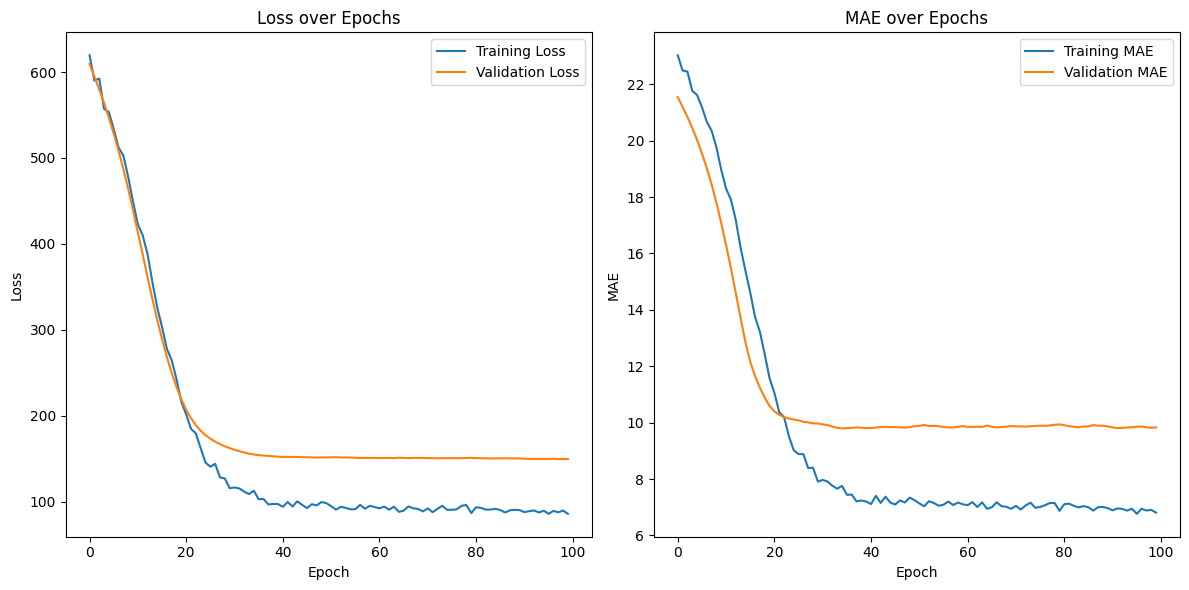

In [18]:

# Plotting metrics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].plot(metrics['loss']['train'], label='Training Loss')
axes[0].plot(metrics['loss']['valid'], label='Validation Loss')
axes[0].set_title('Loss over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(metrics['mae']['train'], label='Training MAE')
axes[1].plot(metrics['mae']['valid'], label='Validation MAE')
axes[1].set_title('MAE over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()

plt.tight_layout()
plt.show()


### Korak 4: Evaluacija mreže

In [20]:

X_test, y_test = torch.FloatTensor(X_test), torch.FloatTensor(y_test.to_numpy())

y_test_predicted = model(X_test)
test_mse = (y_test - t_test_p

In [20]:
test_mse, test_mae = model.evaluate(X_test, y_test)
print ("Test MSE: {}, Test MEA: {}".format(test_mse, test_mae))

6/6 [==============================] - 0s 1ms/step - loss: 18.7604 - mean_absolute_error: 3.5520
Test MSE: 18.760395050048828, Test MEA: 3.5520451068878174


In [21]:
train_mse, train_mae = model.evaluate(X_train, y_train)
print ("Test MSE: {}, Test MEA: {}".format(train_mse, train_mae))

11/11 [==============================] - 0s 1ms/step - loss: 15.2094 - mean_absolute_error: 2.7004
Test MSE: 15.209432601928711, Test MEA: 2.7004189491271973


Ukoliko su nam potrebne i druge metrike evaluacije, možemo iskoristiti funkcije biblioteke `scikit-learn`.

In [22]:
from sklearn import metrics

In [23]:
y_predicted = model.predict(X_test)

In [24]:
metrics.r2_score(y_predicted, y_test)

0.7230361692067216

Keras biblioteka omogućava i definisanje funkcija sa povratnim pozivom (engl. callback functions) kojima se mogu pratiti željene vrednosti na nivou obrade pojedinačnih paketića ili celih epoha. Prilikom opredeljivanja za praćenje ovih metrika treba uzeti u obzir to da li su globalnog ili lokalnog karaktera i da li ih ima smisla uporosečavati u krajnju vrednost ili ne. Na primer, srednjekavadratna greška se može pratiti na nivou paketa i na kraju uprosečiti, dok to ne važi za koeficijent determinacije. 

Sledeći primer ilustruje definisanje omotača koji koristi predefinisane funkcije `on_train_begin` i `on_batch_end`. Slično njima, postoje i funkcije `on_train_end` i `on_batch_begin`, kao i funkcije koje se tiču praćenja epoha `on_epoch_begin` i `on_epoch_end`. Gde je primenljivo, ove funkcije imaju i pridruženi paketić sa podacima (parametar `batch`). Parametar `logs` koji se pominje je trenutno fiktivnog karaktera i uvek ga treba postaviti na {}.

In [25]:
from tensorflow.keras import callbacks

In [26]:
model.metrics_names

['loss', 'mean_absolute_error']

In [27]:
class RegressionHistory(callbacks.Callback):
    # predefinisana funkcija koja ce se izvrsiti na pocetku treniranja
    def on_train_begin(self, logs={}):
        self.mse = []

    # predefinisana funkcija koja ce se izvrsiti na kraju obrade svakog od paketica
    def on_batch_end(self, batch, logs={}):
        self.mse.append(logs.get('loss'))

In [28]:
regression_history = RegressionHistory()

In [29]:
history = model.fit(X_train, y_train, epochs=NUMBER_OF_EPOCHS, batch_size=BATCH_SIZE, verbose=0, validation_split=0.1, callbacks=[regression_history])

Izračunatu metriku, srednjekvadratnu grešku, na nivou svakog paketića možemo dobiti preko niza `regression_history.mse`. 

In [30]:
len(regression_history.mse)

1000

In [31]:
np.average(regression_history.mse)

10.329270200252534

Funkcije sa povratnim pozivom se mogu iskoristiti i za nešto drugačije svrhe. Na primer, često je, ukoliko nema progresa prilikom obučavanja mreže, praktično prevremeno prekinuti obučavanje. Za te svrhe se može koristiti funkcija `EarlyStopping`. Ova funkcija dozvoljava da se parametrom `monitor` naznači metrika koju treba pratiti kao i broj epoha koji treba tolerisati za slučaj da nema progresa - za to se upotrebljava parametar `patience`. Sama funkcija se navodi prilikom poziva metode `fit` u okviru `callbacks` niza. 

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

In [33]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

In [34]:
history = model.fit(X_train, y_train, epochs=NUMBER_OF_EPOCHS, batch_size=BATCH_SIZE, verbose=0, validation_split=0.1, \
                    callbacks=[early_stopping_callback])

In [35]:
print('Broj epoha treniranja: ', len(history.epoch))

Broj epoha treniranja:  16


### Korak 5: Čuvanje modela

Kao što smo napomenuli, za svaki sloj mreže postoji matrica parametara i matrica slobodnih članova. Sve ove matrice se čuvaju u listi `weights` naučenog modela.

In [38]:
print(model.state_dict().keys())
print(type(model.state_dict()))


odict_keys(['model.0.weight', 'model.0.bias', 'model.2.weight', 'model.2.bias'])
<class 'collections.OrderedDict'>


In [41]:
torch.save(model.state_dict(), 'saved_models/model.pth')

In [39]:
for weight_name in model.state_dict():
    print(weight_name, model.state_dict()[weight_name].shape)

model.0.weight torch.Size([100, 13])
model.0.bias torch.Size([100])
model.2.weight torch.Size([1, 100])
model.2.bias torch.Size([1])


Izračunate matrice parametara je moguće sačuvati funkcijom `save_weights` i kasnije upotrebiti. Za čuvanje se može koristiti hdf5 (Hierarchical Data Format version 5) koji podržava čuvanje velikih, kompleksnih i heterogenih podataka.

In [42]:
torch.save(model, 'saved_models/model_full.pth')

Ceo model, uključujući i konfiguraciju i matrice parametara, se može ponovo pročitati i aktivirati funkcijom `load_model` paketa `models`.

In [44]:
model_revived = torch.load('saved_models/model_full.pth')

In [45]:
model.load_state_dict(torch.load('saved_models/model.pth'))

<All keys matched successfully>

Učitani model se može koristiti na način na koji smo to do sada i radili. 

Zajednica koja se bavi mašinskim učenjem ulaže napore da standardizuje formate za čuvanje mreža. Jedan od njih je i [ONNX](https://onnx.ai/) za koji Keras biblioteka nudi [podršku](https://github.com/onnx/onnx-docker/blob/master/onnx-ecosystem/converter_scripts/keras_onnx.ipynb). O ovim temam će svakako biti više reči i u nastavku kursa. 
<img src='assets/onnx.png'>

Ukoliko nam je potreban uvid u samu arhitekturu mreže, možemo generisati i grafički prikaz korišćenjem pomoćnih funkcionalnosti biblioteke keras. Za ova generisanja nam je potrebna i bibliteka `graphviz`.

In [47]:
from torchviz import make_dot 

dummy_input = torch.randn(1, number_of_features).to(torch.device('cuda'))
output = model(dummy_input)
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("model_pytorch", format="png")

'model_pytorch.png'

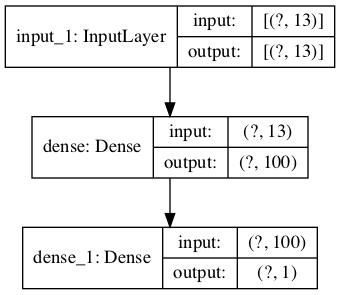

In [46]:
keras.utils.plot_model(model, to_file='model_keras_regresija.png', show_shapes=True)

Na grafiku su prikazana podrazumevana imena slojeva. Adekvatnija imena se mogu zadati svojstvom `name`. 

Vizuelizacije mreže će biti moguće i kroz alat [TensorBoard](https://www.tensorflow.org/tensorboard) koji ćemo, takođe, upoznati na nekom od narednih časova.